# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Akshara Chandrabalan

**ID**: ac2837

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE 5750 /hw02-akshara-c`


In [2]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points) - DONE COMPUTATION, NEED TO EDIT/REFINE AND WRITE ANSWER STATEMENT

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 L</sup>/d | 10,000 L</sup>/d | 15,000 L</sup>/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [4]:
# river, waste stream 1, and waste stream 2 inflows
r_in = 100000
ws1_in = 10000
ws2_in = 15000
# given DO concentrations
r_Ci = 7.5
ws1_Ci = 5
ws2_Ci = 5
# given CBOD concentrations
r_Bi = 5
# given NBOD concentrations
r_Ni = 5

function diss_O2(d, Cs, ws1_Bi, ws2_Bi, ws1_Ni, ws2_Ni, ka, kc, kn, U)
    C0 = ((r_Ci * r_in) + (ws1_Ci * ws1_in))/(r_in + ws1_in)
    B0 = ((r_Bi * r_in) + (ws1_Bi * ws1_in))/(r_in + ws1_in)
    N0 = ((r_Ni * r_in) + (ws1_Ni * ws1_in))/(r_in + ws1_in)
    
    if (d >= 0) && (d <= 15)
        α1 = exp(-ka * d / U) 
        α2 = (kc / (ka - kc)) * (exp(-kc * d / U) - α1)
        α3 = (kn / (ka - kn)) * (exp(-kn * d / U) - α1)

        C = (Cs * (1 - α1)) + (C0 * α1) - (B0 * α2) - (N0 * α3)
        return C
    elseif (d > 15)
        d2 = d - 15

        α1 = exp(-ka * d2 / U) 
        α2 = (kc / (ka - kc)) * (exp(-kc * d2 / U) - α1)
        α3 = (kn / (ka - kn)) * (exp(-kn * d2 / U) - α1)

        C15 = 4.88 # calculated manually
        C15_mix = (((C15 * (r_in + ws1_in)) + (ws2_Ci * ws2_in))/(r_in + ws1_in + ws2_in))   
        B15_mix = (((B0 * exp(-kc * 15 / U)) * (r_in + ws1_in)) + (ws2_Bi * ws2_in))/(r_in + ws1_in + ws2_in)
        N15_mix = (((N0 * exp(-kn * 15 / U)) * (r_in + ws1_in)) + (ws2_Ni * ws2_in))/(r_in + ws1_in + ws2_in)

        C = (Cs * (1 - α1)) + (C15_mix * α1) - (B15_mix * α2) - (N15_mix * α3)
        return C
    else
        throw(error("input d must be greater than 0, enter again"))
    end  
end

# testing function
diss_O2(16, 10, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6)


4.563241063335931

In [5]:
# finding min DO within 50 km downstream
d = collect(0:0.1:50)
C_val = []
for i = 1:length(d)
    C = diss_O2(d[i], 10, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6) 
    append!(C_val, C)
end

min_DO = findmin(C_val)
C_min = round(min_DO[1]; digits = 2)
@show C_min
C_min_dist = d[min_DO[2]];
@show C_min_dist;



C_min = 3.75
C_min_dist = 22.3


C_min and C_max are in mg/L and C_min_dist and C_min_dist are in km. 

### Problem 2 (4 points) - DONE COMPUTATION, NEED TO EDIT/REFINE AND WRITE ANSWER STATEMENT

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

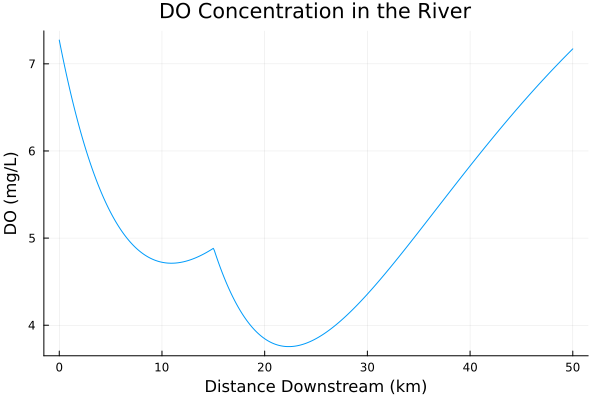

In [6]:
plot(d, C_val, label = false)
xlabel!("Distance Downstream (km)")
ylabel!("DO (mg/L)")
title!("DO Concentration in the River")

### Problem 3 (3 points) - DONE COMPUTATION, NEED TO EDIT/REFINE AND WRITE ANSWER STATEMENT

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [9]:
C = diss_O2(15, 10, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6) 
d = 15

while C <= 6
    C = diss_O2(d, 10, 50, 45, 35, 35, 0.55, 0.35, 0.25, 6)
    d += 0.1 
end
return d 

dist_6 = round(d, digits = 2)

41.3

### Problem 4 (5 points) - DONE COMPUTATION, NEED TO EDIT/REFINE AND WRITE ANSWER STATEMENT

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

trt = 0.11999999999999998
C_min = 4.0
C_min_dist = 21.7


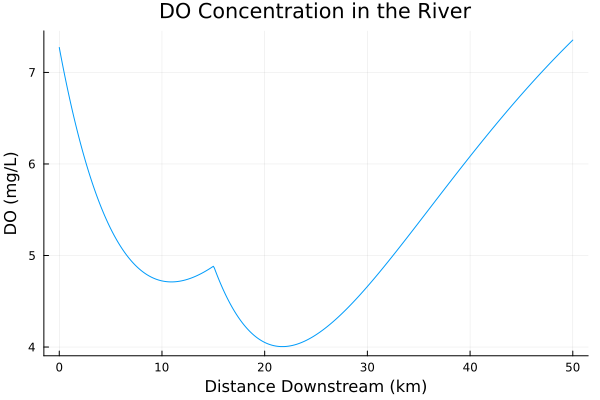

In [39]:
trt = 0

while C_min <= 4
    trt += 0.01
    C_min = diss_O2(C_min_dist, 10, 50, 45*(1-trt), 35, 35*(1-trt), 0.55, 0.35, 0.25, 6)
end

@show trt;

d = collect(0:0.1:50)
C_val_updated = []
for i = 1:length(d)
    C = diss_O2(d[i], 10, 50, 45*(1-trt), 35, 35*(1-trt), 0.55, 0.35, 0.25, 6) 
    append!(C_val_updated, C)
end

min_DO = findmin(C_val_updated)
C_min = round(min_DO[1]; digits = 2)
@show C_min
C_min_dist = d[min_DO[2]];
@show C_min_dist;

plot(d, C_val_updated, label = false)
xlabel!("Distance Downstream (km)")
ylabel!("DO (mg/L)")
title!("DO Concentration in the River")


### Problem 5 (5 points) - DONE COMPUTATION, NEED TO EDIT/REFINE AND WRITE ANSWER STATEMENT

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

trt = 0.09
C_min = 4.0
C_min_dist = 21.7


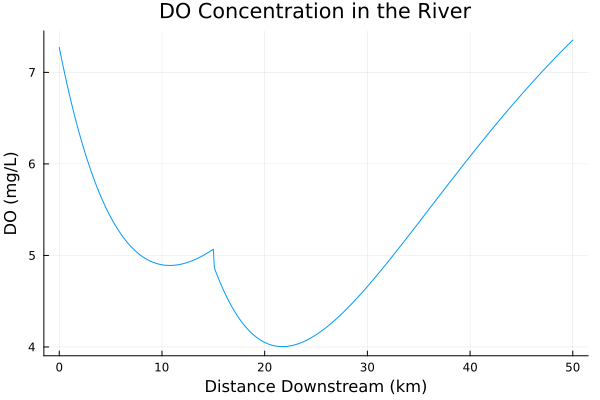

In [41]:
trt = 0

while C_min <= 4
    trt += 0.01
    C_min = diss_O2(C_min_dist, 10, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6)
end

@show trt;

d = collect(0:0.1:50)
C_val_updated = []
for i = 1:length(d)
    C = diss_O2(d[i], 10, 50*(1-trt), 45*(1-trt), 35*(1-trt), 35*(1-trt), 0.55, 0.35, 0.25, 6) 
    append!(C_val_updated, C)
end

min_DO = findmin(C_val_updated)
C_min = round(min_DO[1]; digits = 2)
@show C_min
C_min_dist = d[min_DO[2]];
@show C_min_dist;

plot(d, C_val_updated, label = false)
xlabel!("Distance Downstream (km)")
ylabel!("DO (mg/L)")
title!("DO Concentration in the River")

### Problem 6 (5 points) - NOT DONE

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of
5000 L</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

## References

List any external references consulted, including classmates.

https://www.tutorialspoint.com/julia/julia_arrays.htm

Consulted with: Christine Swanson